## IMPORT DATASET
    - 2 classes. cats and dogs
    - image size = 64
    - image in gray scale


In [96]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize

# parameters that you should set before running this script
filter = ['cat', 'dog']       # select class, this default should yield 1489 training and 1470 validation images
# voc_root_folder = "/Users/ericmassip/Projects/MAI/2nd_semester/CV/Project/VOCdevkit/"  # please replace with the location on your laptop where you unpacked the tarball
voc_root_folder = "C:/Users/Manuel/Documents/MANUEL/KU_LEUVEN_MASTER/COURSES/CV/project/VOCdevkit/"
image_size = 64    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)


# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]

In [97]:
def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y

In [98]:
x_train, y_train = build_classification_dataset(train_files)
print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))
x_val, y_val = build_classification_dataset(val_files)
print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

C:\Users\Manuel\Anaconda2\envs\CV\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Manuel\Anaconda2\envs\CV\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


582 training images from 2 classes
610 validation images from 2 classes


In [99]:
import matplotlib.pyplot as plt
import cv2

def convert_to_grayscale(images):
    return np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images])

In [100]:
x_train_gray = convert_to_grayscale(x_train)
x_val_gray = convert_to_grayscale(x_val)

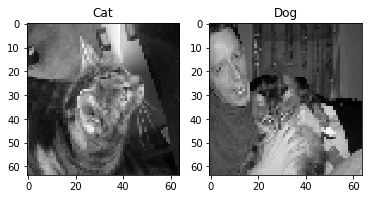

In [101]:
plt.subplot(121)
plt.title('Cat')
plt.imshow(x_train_gray[0], cmap='gray')
plt.subplot(122)
plt.title('Dog')
plt.imshow(x_train_gray[1], cmap='gray')


# AUTOENCODER
    - convolutional autoencoder.
    - reshape layer to get the coding variable

In [110]:
import tensorflow as tf
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Reshape
from keras.models import Model
from keras.optimizers import RMSprop


batch_size = 128
epochs = 10
inChannel = 1
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))

x_train_gray = np.reshape(x_train_gray,(-1,64,64,1))
x_val_gray = np.reshape(x_val_gray,(-1,64,64,1))
    
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(4, 4))(conv2) #7 x 7 x 64
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    
    resh1 = Reshape((512,1,1),)(conv3)
    resh2 = Reshape((8,8,8))(resh1)

    #decoder
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(resh2) #7 x 7 x 128
    up1 = UpSampling2D((4,4))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder_train = autoencoder.fit(x_train_gray, x_train_gray, epochs=epochs,verbose=1,validation_data=(x_val_gray, x_val_gray))



Train on 582 samples, validate on 610 samples
Epoch 1/5
582/582 [==============================] - 19s 32ms/step - loss: 0.0641 - val_loss: 0.0393
Epoch 2/5
582/582 [==============================] - 19s 32ms/step - loss: 0.0407 - val_loss: 0.0363
Epoch 3/5
582/582 [==============================] - 18s 32ms/step - loss: 0.0333 - val_loss: 0.0370
Epoch 4/5
582/582 [==============================] - 18s 32ms/step - loss: 0.0302 - val_loss: 0.0329
Epoch 5/5
582/582 [==============================] - 19s 32ms/step - loss: 0.0283 - val_loss: 0.0262


In [111]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 8, 8, 8)           4616      
_________________________________________________________________
reshape_50 (Reshape)         (None, 512, 1, 1)         0         
__________

In [112]:
output = autoencoder.predict(x_val_gray)

In [113]:
output_resh = np.reshape(output,(-1,64,64))
x_val_gray_resh = np.reshape(x_val_gray,(-1,64,64))

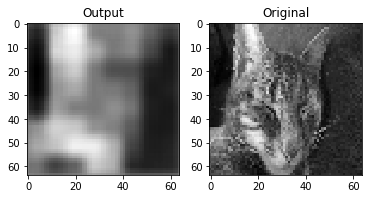

In [114]:
plt.subplot(121)
plt.title('Output')
plt.imshow(output_resh[0], cmap='gray')
plt.subplot(122)
plt.title('Original')
plt.imshow(x_val_gray_resh[0], cmap='gray')